# Modeling exercise

## General Instructions

* Submission date: 25.4.2022
* Submission Method: Link to your solution notebook in [this sheet](https://docs.google.com/spreadsheets/d/1fTmjiVxzw_rM1hdh16enwUTtxzlHSJIiw41dJS2LKp0/edit?usp=sharing).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys; sys.path.append('C:/Users/Liron/ML/Python_ML-2022/Modles and Modeling/src')
import numpy as np
import plotly_express as px

In [3]:
import pandas as pd
import ipywidgets as widgets

In [4]:
from datasets import make_circles_dataframe, make_moons_dataframe

In [5]:
from sklearn.datasets import make_moons

## Fitting and Overfiting 

The goal of the following exercise is to:
* Observe overfitting due to insuffient data
* Observe Overfitting due to overly complex model
* Identify the overfitting point by looking at Train vs Test error dynamic
* Observe how noise levels effect the needed data samples and model capacity

To do so, you'll code an experiment in the first part, and analyze the experiment result in the second part.

### Building an experiment

Code:

1. Create data of size N with noise level of magnitude NL from datasets DS_NAME. 
1. Split it to training and validation data (no need for test set), use 80%-20%. 
1. Use Logistic regression and Choose one complex model of your choice: [KNN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), [SVM with RBF kernel](https://scikit-learn.org/stable/modules/svm.html) with different `gamma` values or [Random forest classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) with differnt number of `min_samples_split`. 
1. Train on the train set for different hyper parameter values. compute:
   1. Classification accuracy on the validation set (TRE)
   1. Classification accuracy on the validation set (TESTE)
   1. The difference beteen the two above (E_DIFF)
1. Save DS_NAME, N, NL, CLF_NAME, K, TRE, TESTE, E_DIFF and the regularization/hyper param (K, gamma or min_samples_split and regularization value for the linear regression classifier)

Repeat for:
* DS_NAME in Moons, Circles
* N (number of samples) in [5, 10, 50, 100, 1000, 10000]
* NL (noise level) in [0, 0.1, 0.2, 0.3, 0.4, 0.5]
* For the complex model: 10 Values of hyper parameter of the complex model you've chosen.
* For the linear model: 5 values of ridge (l2) regularization - [0.001, 0.01, 0.1, 1, 10, 100, 1000]

#### Part 1- Task 1 Creating the datasets

In [6]:
df = pd.DataFrame()
datasets_type = ['circles', 'moons']
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
i = 0
for ds_type in datasets_type:
    for nl in noise_levels:
        if ds_type == 'circles':
            df_current = make_circles_dataframe(n_samples=10000, noise_level = nl)
        if ds_type == 'moons':
            df_current = make_moons_dataframe(n_samples=10000, noise_level = nl)
        df_current.insert(0, 'dataset_name', ds_type)
        df_current.insert(1, 'noise_level', nl)
        df_current.head()
        if i == 1:
            df = df.append(df_current)
        if i == 0:
            df = df_current
            i += 1
df.sample(120)

,dataset_name,noise_level,x,y,label
7502,circles,0.1,-0.534694,0.891020,A
2664,moons,0.4,1.706223,0.064479,B
6042,circles,0.5,-1.233362,0.491509,A
7509,moons,0.4,1.089743,-0.529402,A
7952,circles,0.5,-0.454038,-0.672778,A
...,...,...,...,...,...
3918,moons,0.3,-0.671067,0.779204,A
4399,circles,0.2,0.223780,0.921990,A
3717,moons,0.3,1.672670,-0.019621,B
4008,moons,0.2,1.212281,-0.609070,B


In [7]:
df.groupby(["dataset_name", "noise_level"])['label'].count()

dataset_name  noise_level
circles       0.0            10000
              0.1            10000
              0.2            10000
              0.3            10000
              0.4            10000
              0.5            10000
moons         0.0            10000
              0.1            10000
              0.2            10000
              0.3            10000
              0.4            10000
              0.5            10000
Name: label, dtype: int64

datasets_type = ['circles', 'moons']
k_folds = 10
n_samples = [10, 50, 100, 1000, 10000]
noise_levels = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
clf_types = ['log_reg', 'svm']
hp_range = [0.01, 0.1, 1, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
regularization_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []


for ds_type in datasets_type:
    print(f'Working on {ds_type}')
    for nl in noise_levels:
        for n in n_samples:
            str = f"dataset_name == '{ds_type}' and noise_level == {nl}"
            # print(str)
            ds = df.query(str).head(n)
            print(f'Starting {k_folds}-fold cross validation for {ds_type} datasets with {n} samples and noise level {nl}. Going to train {clf_types} classifiers.')
            for k in range(k_folds):
                ds['fold_id'] = ds.index.map(lambda x: x%10)

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

## Coding the experiment

In [11]:
datasets_type = ['circles', 'moons']
k_folds = 10
k_for_5_folds = 5
n_samples = [5, 10, 50, 100, 1000, 10000]
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5]
clf_types = ['log_reg', 'svm']
hp_range = [0.01, 0.1, 1, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000]
regularization_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
results = []
for ds_type in datasets_type:
    print(f'Working on {ds_type}')
    for nl in noise_levels:
        for n in n_samples:
            str = f"dataset_name == '{ds_type}' and noise_level == {nl}"
#            print(str)
            ds = df.query(str).head(n)
            print('\n')
            print(f'Starting {k_folds}-fold cross validation for {ds_type} datasets with {n} samples and noise level {nl} \nGoing to train {clf_types} classifiers.')
### adding a k-fold column to slice and dice data accordingly
            
            if n > 5: k_folds = 10
            if n < 10: k_folds = 5
            
            ds['fold_id'] = ds.index.map(lambda x: x % k_folds)
            
            for k in range(k_folds):
                str = f"fold_id != {k}"
                data_to_model = ds.query(str)
                X = data_to_model[['x','y']]
                Y = data_to_model[['label']]
                data_k_fold = ds.query( f"fold_id == {k}")
                X_k_fold = data_k_fold[['x','y']]
                Y_k_fold = data_k_fold[['label']]
                Y_k_fold = Y_k_fold.values.ravel()
                print('\n')
                print(f'Currently validating fold number {k}, Size of train sample {X.size} ,size of labels data {Y.size} \n')

                ###  This block is for catching folds with only one type of label
                try:
                    number_of_B_values_in_subset_group = Y.label.value_counts()['B']
                except:
                    number_of_B_values_in_subset_group = 0

                if (number_of_B_values_in_subset_group == 0 or number_of_B_values_in_subset_group == Y.size): 
                    continue
                ###  END OF BLOCK - This block is for catching folds with only one type of label
                #print(X)
                #print('\n')
                #print(Y)
                #print('\n')
                #print(f'number of B-s {number_of_B_values_in_subset_group}')

                x_train,x_test,y_train,y_test= train_test_split(X,Y, test_size=0.2, random_state=42)
                #print(y_train)
                
                ###  This block is for catching y_train with only one type of label
                try:
                    number_of_B_values_in_train_group = y_train.label.value_counts()['B']
                #    print(f'number of B values in y_train is {number_of_B_values_in_train_group}')
                except:
                    number_of_B_values_in_train_group = 0

                if (number_of_B_values_in_train_group == 0 or number_of_B_values_in_train_group == y_train.size): 
                #    print('Decided to continue *****************   \n')
                    continue
                ###  END OF BLOCK - This block is for catching y_train with only one type of label


#                print(x_train.size, x_test.size, y_train.size, y_test.size)
                for clf_type in clf_types:
                    if clf_type == 'log_reg':
                        for regularization_value in regularization_values:
                            print(f'Regularization value now is {regularization_value}')
                            clf = LogisticRegression(C= regularization_value, random_state=0).fit(x_train, y_train.values.ravel())
                            train_acc = accuracy_score(clf.predict(x_test),y_test)
                            test_acc = accuracy_score(clf.predict(X_k_fold),Y_k_fold)
                            print(f'train accuracy = {train_acc}, test accuracy = {test_acc}')
                            results.append([ds_type, nl, n, k, clf_type, regularization_value, train_acc, test_acc])
                    if clf_type == 'svm':
                        for gamma in hp_range:
                            clf = SVC(C=1, gamma=gamma)
                            clf.fit(x_train, y_train.values.ravel())
                            y_test_pred = clf.predict(x_test)
                            y_k_pred = clf.predict(X_k_fold)
                            train_acc = accuracy_score(y_test, y_test_pred) 
                            test_acc = accuracy_score(Y_k_fold, y_k_pred)
                            print(f'for gamma {gamma} the train accuracy is {train_acc} and the test accuracy is {test_acc}\n')
                            results.append([ds_type, nl, n, k, clf_type, gamma, train_acc, test_acc])
                            

Working on circles


Starting 10-fold cross validation for circles datasets with 5 samples and noise level 0 
Going to train ['log_reg', 'svm'] classifiers.


Currently validating fold number 0, Size of train sample 8 ,size of labels data 4 



Currently validating fold number 1, Size of train sample 8 ,size of labels data 4 

Regularization value now is 0.001
train accuracy = 1.0, test accuracy = 1.0
Regularization value now is 0.01
train accuracy = 1.0, test accuracy = 1.0
Regularization value now is 0.1
train accuracy = 1.0, test accuracy = 1.0
Regularization value now is 1
train accuracy = 1.0, test accuracy = 1.0
Regularization value now is 10
train accuracy = 1.0, test accuracy = 0.0
Regularization value now is 100
train accuracy = 1.0, test accuracy = 0.0
Regularization value now is 1000
train accuracy = 1.0, test accuracy = 0.0
for gamma 0.01 the train accuracy is 1.0 and the test accuracy is 1.0

for gamma 0.1 the train accuracy is 1.0 and the test accuracy is 1.0

for gamma 1

In [15]:
res = pd.DataFrame(results)
res.columns = ['data_model','noise_level','sample_size','k_fold_id','prediction_model', 'hyperparameter','train_accuracy','test_accuracy'] 
res.sample(50)

,data_model,noise_level,sample_size,k_fold_id,prediction_model,hyperparameter,train_accuracy,test_accuracy
3706,circles,0.4,5,0,log_reg,1.000000e-03,1.000000,0.000
6224,moons,0.0,1000,6,log_reg,1.000000e-01,0.816667,0.870
4859,circles,0.5,10,7,svm,1.000000e+06,0.500000,1.000
6123,moons,0.0,1000,0,log_reg,1.000000e+00,0.872222,0.870
1148,circles,0.1,10,9,svm,1.000000e+00,0.500000,0.000
8395,moons,0.3,10,2,svm,1.000000e+06,0.000000,0.000
11002,moons,0.5,10000,9,log_reg,1.000000e+00,0.803333,0.805
10256,moons,0.5,10,5,log_reg,1.000000e+02,0.500000,1.000
589,circles,0.0,1000,0,svm,1.000000e+03,1.000000,1.000
5040,circles,0.5,50,8,svm,1.000000e-01,0.666667,0.400


In [16]:
res.to_csv('res_from_models_run.csv', sep='\t')

### Analysing the expermient results

1. What is the best model and model params? How stable is it? 
1. What is the most stable model and model params? How good is it? 
1. Does regularization help for linear models? 
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? 
1. For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? 
1. Are the noise level effect the number of datapoints needed to reach minimal test results? 
1. Select the best model param to fit the data (The one minimizing the test error) and for it, observe the number of data points needed for optimal test results in different noise levels.

### From K-fold to mean and standard deviation results

In [18]:
res.tail()

,data_model,noise_level,sample_size,k_fold_id,prediction_model,hyperparameter,train_accuracy,test_accuracy
11011,moons,0.5,10000,9,svm,10000.0,0.666667,0.648
11012,moons,0.5,10000,9,svm,100000.0,0.541111,0.527
11013,moons,0.5,10000,9,svm,1000000.0,0.503333,0.501
11014,moons,0.5,10000,9,svm,10000000.0,0.502778,0.496
11015,moons,0.5,10000,9,svm,100000000.0,0.502778,0.494


In [19]:
### abs() is used so we can get the minimal E_Diff regardless of direction
res['E_DIFF'] = abs(res['train_accuracy'] - res['test_accuracy'])
res.tail()

,data_model,noise_level,sample_size,k_fold_id,prediction_model,hyperparameter,train_accuracy,test_accuracy,E_DIFF
11011,moons,0.5,10000,9,svm,10000.0,0.666667,0.648,0.018667
11012,moons,0.5,10000,9,svm,100000.0,0.541111,0.527,0.014111
11013,moons,0.5,10000,9,svm,1000000.0,0.503333,0.501,0.002333
11014,moons,0.5,10000,9,svm,10000000.0,0.502778,0.496,0.006778
11015,moons,0.5,10000,9,svm,100000000.0,0.502778,0.494,0.008778


In [21]:
def f(x):
    d = {}
    d['train_acc_mean'] = x['train_accuracy'].mean()
    d['train_acc_std'] = x['train_accuracy'].std()
    d['test_acc_mean'] = x['test_accuracy'].mean()
    d['test_acc_std'] = x['test_accuracy'].std()
    d['E_DIFF_mean'] = x['E_DIFF'].mean()
    d['E_DIFF_std'] = x['E_DIFF'].std()
    return pd.Series(d, index=['train_acc_mean', 'train_acc_std', 'test_acc_mean', 'test_acc_std','E_DIFF_mean','E_DIFF_std'])

grouped_res = res.groupby(['data_model','noise_level','sample_size','prediction_model','hyperparameter']).apply(f)
grouped_res.head()

train_acc_mean  \
data_model noise_level sample_size prediction_model hyperparameter                   
circles    0.0         5           log_reg          0.001                     1.00   
                                                    0.010                     1.00   
                                                    0.100                     1.00   
                                                    1.000                     0.75   
                                                    10.000                    0.25   

                                                                    train_acc_std  \
data_model noise_level sample_size prediction_model hyperparameter                  
circles    0.0         5           log_reg          0.001                     0.0   
                                                    0.010                     0.0   
                                                    0.100                     0.0   
                                                    1.000                     0.5   
                                                    10.000                    0.5   

                                                                    test_acc_mean  \
data_model noise_level sample_size prediction_model hyperparameter                  
circles    0.0         5           log_reg          0.001                     1.0   
                                                    0.010                     1.0   
                                                    0.100                     1.0   
                                                    1.000                     1.0   
                                                    10.000                    0.5   

                                                                    test_acc_std  \
data_model noise_level sample_size prediction_model hyperparameter                 
circles    0.0         5           log_reg          0.001                0.00000   
                                                    0.010                0.00000   
                                                    0.100                0.00000   
                                                    1.000                0.00000   
                                                    10.000               0.57735   

                                                                    E_DIFF_mean  \
data_model noise_level sample_size prediction_model hyperparameter                
circles    0.0         5           log_reg          0.001                  0.00   
                                                    0.010                  0.00   
                                                    0.100                  0.00   
                                                    1.000                  0.25   
                                                    10.000                 0.75   

                                                                    E_DIFF_std  
data_model noise_level sample_size prediction_model hyperparameter              
circles    0.0         5           log_reg          0.001                  0.0  
                                                    0.010                  0.0  
                                                    0.100                  0.0  
                                                    1.000                  0.5  
                                                    10.000                 0.5

### Q1 - Analysis

In [24]:
pd.set_option('display.max_rows', 110)
#generally checking which models succeeded most to predict with as few errors as possible
grouped_res.query('E_DIFF_mean == 0')

train_acc_mean  \
data_model noise_level sample_size prediction_model hyperparameter                   
circles    0.0         5           log_reg          1.000000e-03               1.0   
                                                    1.000000e-02               1.0   
                                                    1.000000e-01               1.0   
                                   svm              1.000000e-02               1.0   
                                                    1.000000e-01               1.0   
                                                    1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
                                                    1.000000e+04               1.0   
                                                    1.000000e+05               1.0   
                                                    1.000000e+06               1.0   
                                                    1.000000e+07               1.0   
                                                    1.000000e+08               1.0   
                       1000        svm              1.000000e+00               1.0   
                                                    1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
                       10000       svm              1.000000e-01               1.0   
                                                    1.000000e+00               1.0   
                                                    1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
                                                    1.000000e+04               1.0   
                                                    1.000000e+05               1.0   
           0.4         5           log_reg          1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
moons      0.0         5           log_reg          1.000000e-03               1.0   
                                                    1.000000e-02               1.0   
                                                    1.000000e-01               1.0   
                                                    1.000000e+00               1.0   
                                                    1.000000e+01               1.0   
                                                    1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
                                   svm              1.000000e-02               1.0   
                                                    1.000000e-01               1.0   
                                                    1.000000e+00               1.0   
                                                    1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
                                                    1.000000e+04               1.0   
                                                    1.000000e+05               1.0   
                                                    1.000000e+06               1.0   
                                                    1.000000e+07               1.0   
                                                    1.000000e+08               1.0   
                       50          svm              1.000000e+00               1.0   
                       100         svm              1.000000e+00               1.0   
                       1000        svm              1.000000e+00               1.0   
                                                    1.000000e+02               1.0   
                                                    1.000000e+03               1.0   
                       100

**We can see that the best models are those who are at one of the following categories:**
1. no noise, noise level = 0 - it is easy for the model to recognize the pattern
1. small noise (=0.1) and small number of samples (=10) has the possibility of randomly acheiving high predicitve score because the test size is so small it becomes very binary - either success or failure
1. The only outlier is the SVM model that can predict very well in a slight noise situation (=0.1) even when sample size is 100 or 1000


### Q2 - Analysis

**What is the most stable model and model params? How good is it?**

1. we can see from the previous question, many models with "easier lifes" because there are no samples or noise - so the answer stays the same.
1. in the next code snippet I'll show data from models that didn't guess all of the correct information - meaning test accuracy less than 1

In [25]:
# removing the groupedby columns as index
grouped_res2 = res.groupby(['data_model','noise_level','sample_size','prediction_model','hyperparameter'], as_index=False).apply(f)

In [26]:
pd.options.display.max_rows
grouped_res2.query('noise_level > 0 and test_acc_std > 0 and data_model == "circles"').sort_values(by=['test_acc_std','test_acc_mean'], ascending=True).head(25)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
404,circles,0.3,10000,svm,100000.0,0.495222,0.011616,0.4960,0.004876,0.009444,0.008196
405,circles,0.3,10000,svm,1000000.0,0.494111,0.006270,0.4941,0.007978,0.009700,0.007846
406,circles,0.3,10000,svm,10000000.0,0.493444,0.007026,0.4953,0.008179,0.010011,0.008038
407,circles,0.3,10000,svm,100000000.0,0.493333,0.006672,0.4952,0.008377,0.010222,0.008035
402,circles,0.3,10000,svm,1000.0,0.565111,0.007540,0.5667,0.009286,0.012567,0.004866
195,circles,0.1,10000,svm,0.1,0.849222,0.006270,0.8368,0.010401,0.014867,0.009197
609,circles,0.5,10000,svm,1000000.0,0.487833,0.006654,0.4972,0.010840,0.015500,0.008142
610,circles,0.5,10000,svm,10000000.0,0.486333,0.006642,0.4964,0.011037,0.016133,0.008911
611,circles,0.5,10000,svm,100000000.0,0.486278,0.006527,0.4964,0.011037,0.016078,0.008907
505,circles,0.4,10000,svm,10000.0,0.517444,0.018480,0.5178,0.011263,0.022267,0.011341


In [27]:
pd.options.display.max_rows
grouped_res2.query('noise_level > 0 and test_acc_std > 0 and data_model == "moons"').sort_values(by=['test_acc_std','test_acc_mean'], ascending=True).head(25)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
808,moons,0.1,10000,svm,1.000000e+00,0.999889,0.000234,0.9992,0.000789,0.000689,0.000792
809,moons,0.1,10000,svm,1.000000e+02,0.999944,0.000176,0.9991,0.000876,0.000844,0.000813
810,moons,0.1,10000,svm,1.000000e+03,0.996833,0.001257,0.9972,0.001619,0.000789,0.000805
791,moons,0.1,1000,svm,1.000000e+00,1.000000,0.000000,0.9980,0.004216,0.002000,0.004216
1012,moons,0.3,10000,svm,1.000000e+00,0.911167,0.003605,0.9136,0.004600,0.005478,0.003342
1013,moons,0.3,10000,svm,1.000000e+02,0.911056,0.004673,0.9127,0.005100,0.007133,0.003109
1217,moons,0.5,10000,svm,1.000000e+02,0.821722,0.003399,0.8130,0.005142,0.010211,0.004945
807,moons,0.1,10000,svm,1.000000e-01,0.963778,0.002830,0.9628,0.005978,0.004911,0.004571
1014,moons,0.3,10000,svm,1.000000e+03,0.892500,0.005721,0.8928,0.006125,0.007922,0.005042
811,moons,0.1,10000,svm,1.000000e+04,0.972500,0.006177,0.9776,0.006535,0.005878,0.003336


<font color='purple'>**We can see that for stability, a large sample size is required**</font>

For the moons dataset with 10,000 samples and noise level = 0.1, the SVM model is the best with 99.8% prediction accuracy and a very low standard deviation of ~0.0008



### Q3 - Analysis
Does regularization help for linear models? 

**It helps very slightly at best**

In [33]:
grouped_res2.query('prediction_model == "log_reg" and noise_level > 0 and test_acc_mean < 1 and data_model == "circles"').sort_values(by=['noise_level','sample_size','E_DIFF_mean','E_DIFF_std'], ascending=[False,False,True,True]).head(25)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
595,circles,0.5,10000,log_reg,0.001,0.495722,0.014072,0.4987,0.019861,0.009889,0.006637
600,circles,0.5,10000,log_reg,100.000,0.505056,0.014977,0.5025,0.016366,0.011267,0.005786
601,circles,0.5,10000,log_reg,1000.000,0.505056,0.014977,0.5025,0.016366,0.011267,0.005786
598,circles,0.5,10000,log_reg,1.000,0.504833,0.014880,0.5025,0.016521,0.011467,0.005799
599,circles,0.5,10000,log_reg,10.000,0.505056,0.014977,0.5025,0.016521,0.011467,0.005855
597,circles,0.5,10000,log_reg,0.100,0.504278,0.014318,0.5026,0.017037,0.011878,0.005790
596,circles,0.5,10000,log_reg,0.010,0.504778,0.013861,0.5038,0.020428,0.012422,0.006884
578,circles,0.5,1000,log_reg,0.001,0.518889,0.023744,0.5170,0.029833,0.025000,0.017437
579,circles,0.5,1000,log_reg,0.010,0.521111,0.029952,0.5220,0.032592,0.028444,0.013860
582,circles,0.5,1000,log_reg,10.000,0.526111,0.031758,0.5070,0.033015,0.029556,0.022808


### Q4 - Analysis
For a given noise level of your chioce, How does the train, test and difference error changes with increasing data sizes? 

In [34]:
grouped_res2.query('noise_level == 0.3 and data_model == "circles"').sort_values(by=['E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [True, False, False]).head(50)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
404,circles,0.3,10000,svm,1.000000e+05,0.495222,0.011616,0.4960,0.004876,0.009444,0.008196
405,circles,0.3,10000,svm,1.000000e+06,0.494111,0.006270,0.4941,0.007978,0.009700,0.007846
406,circles,0.3,10000,svm,1.000000e+07,0.493444,0.007026,0.4953,0.008179,0.010011,0.008038
407,circles,0.3,10000,svm,1.000000e+08,0.493333,0.006672,0.4952,0.008377,0.010222,0.008035
391,circles,0.3,10000,log_reg,1.000000e-03,0.491556,0.019211,0.4932,0.022943,0.011067,0.005718
400,circles,0.3,10000,svm,1.000000e+00,0.619278,0.006677,0.6278,0.013742,0.011633,0.010949
402,circles,0.3,10000,svm,1.000000e+03,0.565111,0.007540,0.5667,0.009286,0.012567,0.004866
392,circles,0.3,10000,log_reg,1.000000e-02,0.495833,0.023078,0.4985,0.026332,0.013956,0.009501
398,circles,0.3,10000,svm,1.000000e-02,0.503722,0.017183,0.5054,0.023368,0.014656,0.011389
401,circles,0.3,10000,svm,1.000000e+02,0.594222,0.005775,0.6059,0.014433,0.015189,0.010110


<font color='blue'>**We can see that for small samples, there is higher overfitting where the train_accuracy is up to 1.0 but the test accuracy is much lower which creates a very high E_DIFF mean - up to 0.4 which is 40% difference in results between test and train** 
</font>

<font color='green'>**Generally speaking, higher sample size reduces E_DIFF, but as for the train and test accuracy, the hyperparamter and regularization value are meaningful in setting a better model** 
</font>

In [37]:
grouped_res2.query('noise_level == 0.3 and data_model == "moons"').sort_values(by=['prediction_model','hyperparameter','sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [True,True,False,True, False, False]).head(50)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
1003,moons,0.3,10000,log_reg,0.001,0.814389,0.003003,0.8208,0.010861,0.010300,0.006655
986,moons,0.3,1000,log_reg,0.001,0.732778,0.013212,0.7750,0.041164,0.053778,0.034075
969,moons,0.3,100,log_reg,0.001,0.494444,0.142123,0.5400,0.177639,0.114444,0.083156
952,moons,0.3,50,log_reg,0.001,0.544444,0.035136,0.5800,0.147573,0.128889,0.080329
935,moons,0.3,10,log_reg,0.001,0.400000,0.459468,0.1000,0.316228,0.400000,0.459468
918,moons,0.3,5,log_reg,0.001,1.000000,0.000000,1.0000,0.000000,0.000000,0.000000
1004,moons,0.3,10000,log_reg,0.010,0.836889,0.004118,0.8471,0.008478,0.011900,0.007800
987,moons,0.3,1000,log_reg,0.010,0.765000,0.009091,0.8120,0.045656,0.052556,0.043767
970,moons,0.3,100,log_reg,0.010,0.861111,0.087841,0.7500,0.206828,0.117778,0.121851
953,moons,0.3,50,log_reg,0.010,0.544444,0.035136,0.5800,0.147573,0.128889,0.080329


<font color='blue'>**We can see that the moons dataset is even more consistent (relatively) with this conclusion** 
</font>



### Q5 - Analysis
For a given noise level of your chioce, How does the train, test and difference error changes with increasing model complexity? 


**Noise level = 0.4**

In [38]:
grouped_res2.query('noise_level == 0.4 and data_model == "moons" and prediction_model == "log_reg"').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
1107,moons,0.4,10000,log_reg,0.100,0.837222,0.005914,0.8330,0.008273,0.008889,0.008013
1108,moons,0.4,10000,log_reg,1.000,0.838111,0.005661,0.8332,0.009187,0.009511,0.008673
1110,moons,0.4,10000,log_reg,100.000,0.838111,0.005588,0.8330,0.009393,0.009711,0.008641
1111,moons,0.4,10000,log_reg,1000.000,0.838111,0.005588,0.8330,0.009393,0.009711,0.008641
1109,moons,0.4,10000,log_reg,10.000,0.838056,0.005582,0.8330,0.009393,0.009767,0.008646
1106,moons,0.4,10000,log_reg,0.010,0.833722,0.006378,0.8308,0.008324,0.010589,0.006602
1105,moons,0.4,10000,log_reg,0.001,0.813389,0.005764,0.8105,0.010680,0.012844,0.008201
1090,moons,0.4,1000,log_reg,0.100,0.819444,0.009166,0.8340,0.042740,0.032111,0.030638
1089,moons,0.4,1000,log_reg,0.010,0.802778,0.009886,0.8180,0.043153,0.032111,0.030187
1093,moons,0.4,1000,log_reg,100.000,0.806667,0.012228,0.8350,0.033082,0.035222,0.019359


In [39]:
grouped_res2.query('noise_level == 0.4 and data_model == "moons" and prediction_model == "svm"').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
1116,moons,0.4,10000,svm,1.000000e+03,0.823389,0.003566,0.8228,0.008377,0.005567,0.003967
1115,moons,0.4,10000,svm,1.000000e+02,0.855611,0.004370,0.8568,0.007642,0.006856,0.005986
1112,moons,0.4,10000,svm,1.000000e-02,0.836278,0.005374,0.8321,0.008157,0.009089,0.006902
1114,moons,0.4,10000,svm,1.000000e+00,0.858167,0.004328,0.8610,0.008944,0.009722,0.005690
1117,moons,0.4,10000,svm,1.000000e+04,0.703667,0.013589,0.7004,0.016595,0.011000,0.011159
1113,moons,0.4,10000,svm,1.000000e-01,0.855333,0.005643,0.8500,0.011972,0.011733,0.009302
1118,moons,0.4,10000,svm,1.000000e+05,0.533667,0.009367,0.5180,0.011643,0.019489,0.009292
1120,moons,0.4,10000,svm,1.000000e+07,0.499167,0.006248,0.4839,0.013601,0.020356,0.011427
1121,moons,0.4,10000,svm,1.000000e+08,0.499222,0.006448,0.4832,0.013579,0.020911,0.011529
1119,moons,0.4,10000,svm,1.000000e+06,0.503833,0.008456,0.4863,0.013752,0.021600,0.013007


**Zooming for example on the 1000 samples dataset, we can see that the complex model (SVM) is very sensitive to its hyperparameters - at best with hyperparameter Gamma = 1 it shows 83% accuracy but falls to 45% with Gamma 10^8.**

**On the other hand - Logistic regression is far less sensitive than SVM (less biased) and shows a range of between 80.5% and 72%**

In [40]:
grouped_res2.query('noise_level == 0.4 and data_model == "circles" and prediction_model == "log_reg" and sample_size == 1000').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
476,circles,0.4,1000,log_reg,0.001,0.455556,0.021911,0.498,0.035528,0.048222,0.044303
479,circles,0.4,1000,log_reg,1.000,0.438333,0.037811,0.460,0.042164,0.062556,0.041256
478,circles,0.4,1000,log_reg,0.100,0.436111,0.035933,0.467,0.041110,0.064444,0.042755
480,circles,0.4,1000,log_reg,10.000,0.438889,0.039109,0.461,0.046536,0.066111,0.044851
481,circles,0.4,1000,log_reg,100.000,0.438889,0.039109,0.461,0.046536,0.066111,0.044851
482,circles,0.4,1000,log_reg,1000.000,0.438889,0.039109,0.461,0.046536,0.066111,0.044851
477,circles,0.4,1000,log_reg,0.010,0.432778,0.024209,0.478,0.043919,0.066556,0.034480


In [41]:
grouped_res2.query('noise_level == 0.4 and data_model == "circles" and prediction_model == "svm" and sample_size == 1000').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
487,circles,0.4,1000,svm,1.000000e+03,0.504444,0.013042,0.522,0.032249,0.028667,0.021772
488,circles,0.4,1000,svm,1.000000e+04,0.482778,0.018602,0.506,0.037476,0.039222,0.028168
486,circles,0.4,1000,svm,1.000000e+02,0.530000,0.028473,0.543,0.057359,0.043444,0.033092
489,circles,0.4,1000,svm,1.000000e+05,0.459444,0.019431,0.500,0.038006,0.045889,0.042614
483,circles,0.4,1000,svm,1.000000e-02,0.458333,0.020496,0.501,0.040401,0.048444,0.044633
490,circles,0.4,1000,svm,1.000000e+06,0.458333,0.020496,0.501,0.040401,0.048444,0.044633
491,circles,0.4,1000,svm,1.000000e+07,0.458333,0.020496,0.501,0.040401,0.048444,0.044633
492,circles,0.4,1000,svm,1.000000e+08,0.458333,0.020496,0.501,0.040401,0.048444,0.044633
485,circles,0.4,1000,svm,1.000000e+00,0.547222,0.023607,0.543,0.053759,0.049778,0.027740
484,circles,0.4,1000,svm,1.000000e-01,0.566667,0.024003,0.551,0.053009,0.054111,0.031981


**Circles dataset with focused only on sample 1000 - shows the same result of Log_regression being less accurate at its top but also less sensitive to hyperparameter tuning as SVM**

### Q6 - Analysis
Are the noise level effect the number of datapoints needed to reach minimal test results? 

<font color='blue'>**Absolutely - see results for Q1, there we can see that for noise level = 0.0, models are able to gain high test mean prediction capabilities even on sample size 10 all the way through 100, 1000, 10000**</font>

<font color='blue'>**this doesn't happen for small samples with higher noise level** 
</font>



### Q7 - Analysis
Select the best model param to fit the data (The one minimizing the test error) and for it, observe the number of data points needed for optimal test results in different noise levels.





In [42]:
grouped_res2.query('noise_level == 0.0 and data_model == "moons" and prediction_model == "svm" and hyperparameter == 0.1').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
705,moons,0.0,10000,svm,0.1,0.996278,0.000830,0.9972,0.001874,0.002056,0.001125
688,moons,0.0,1000,svm,0.1,0.888333,0.016449,0.8970,0.014944,0.022889,0.011064
671,moons,0.0,100,svm,0.1,0.972222,0.029280,0.9100,0.099443,0.084444,0.087989
654,moons,0.0,50,svm,0.1,0.855556,0.074994,0.9200,0.103280,0.100000,0.076444
637,moons,0.0,10,svm,0.1,0.400000,0.316228,0.5000,0.527046,0.600000,0.316228
620,moons,0.0,5,svm,0.1,1.000000,0.000000,1.0000,0.000000,0.000000,0.000000


**Noise level = 0.0, optimal sample size = 10 for test_accuracy_mean but 10,000 for lower E_DIFF_std variance**

In [43]:
grouped_res2.query('noise_level == 0.1 and data_model == "moons" and prediction_model == "svm" and hyperparameter == 0.1').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
807,moons,0.1,10000,svm,0.1,0.963778,0.002830,0.9628,0.005978,0.004911,0.004571
790,moons,0.1,1000,svm,0.1,0.907222,0.005885,0.8910,0.044083,0.035778,0.030428
773,moons,0.1,100,svm,0.1,0.855556,0.028689,0.8500,0.108012,0.083333,0.085306
756,moons,0.1,50,svm,0.1,0.688889,0.136586,0.7600,0.183787,0.177778,0.105279
739,moons,0.1,10,svm,0.1,0.600000,0.210819,0.7000,0.483046,0.500000,0.235702
722,moons,0.1,5,svm,0.1,0.250000,0.500000,0.5000,0.577350,0.750000,0.500000


**Noise level = 0.1, optimal sample size = 10 for test_accuracy_mean but 10,000 for lower E_DIFF_std variance**

In [44]:
grouped_res2.query('noise_level == 0.2 and data_model == "moons" and prediction_model == "svm" and hyperparameter == 0.1').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
909,moons,0.2,10000,svm,0.1,0.925222,0.003752,0.9234,0.012456,0.013178,0.008310
892,moons,0.2,1000,svm,0.1,0.839444,0.009241,0.8880,0.032931,0.052556,0.031458
875,moons,0.2,100,svm,0.1,0.900000,0.023424,0.9100,0.073786,0.067778,0.060959
858,moons,0.2,50,svm,0.1,0.900000,0.035136,0.9200,0.103280,0.113333,0.032203
841,moons,0.2,10,svm,0.1,1.000000,0.000000,1.0000,0.000000,0.000000,0.000000
824,moons,0.2,5,svm,0.1,1.000000,0.000000,1.0000,0.000000,0.000000,0.000000


**Noise level = 0.2, optimal sample size = 10,000, although 1000 samples shows less variance**

In [45]:
grouped_res2.query('noise_level == 0.3 and data_model == "moons" and prediction_model == "svm" and hyperparameter == 0.1').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
1011,moons,0.3,10000,svm,0.1,0.875667,0.005585,0.885,0.009603,0.011222,0.007288
994,moons,0.3,1000,svm,0.1,0.817778,0.006307,0.858,0.028206,0.041556,0.027543
977,moons,0.3,100,svm,0.1,0.938889,0.017568,0.850,0.108012,0.113333,0.084262
960,moons,0.3,50,svm,0.1,0.900000,0.081985,0.920,0.103280,0.135556,0.072917
943,moons,0.3,10,svm,0.1,0.500000,0.408248,0.200,0.421637,0.600000,0.394405
926,moons,0.3,5,svm,0.1,1.000000,0.000000,1.000,0.000000,0.000000,0.000000


**Noise level = 0.3, optimal sample size = 10,000**

In [46]:
grouped_res2.query('noise_level == 0.4 and data_model == "moons" and prediction_model == "svm" and hyperparameter == 0.1').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
1113,moons,0.4,10000,svm,0.1,0.855333,0.005643,0.850,0.011972,0.011733,0.009302
1096,moons,0.4,1000,svm,0.1,0.815000,0.017183,0.841,0.031073,0.033111,0.025336
1079,moons,0.4,100,svm,0.1,0.738889,0.058853,0.770,0.125167,0.095556,0.106857
1062,moons,0.4,50,svm,0.1,0.844444,0.140546,0.740,0.164655,0.206667,0.132114
1045,moons,0.4,10,svm,0.1,1.000000,0.000000,0.700,0.483046,0.300000,0.483046
1028,moons,0.4,5,svm,0.1,0.400000,0.547723,0.000,0.000000,0.400000,0.547723


**Noise level = 0.4, optimal sample size = 10,000 - judging by E_DIFF_mean, not just by test_accuracy which shows a sample of 100**

In [47]:
grouped_res2.query('noise_level == 0.5 and data_model == "moons" and prediction_model == "svm" and hyperparameter == 0.1').sort_values(by=['sample_size','E_DIFF_mean','test_acc_mean','train_acc_mean'], ascending= [False, True, False,False]).head(21)

,data_model,noise_level,sample_size,prediction_model,hyperparameter,train_acc_mean,train_acc_std,test_acc_mean,test_acc_std,E_DIFF_mean,E_DIFF_std
1215,moons,0.5,10000,svm,0.1,0.824278,0.002772,0.8162,0.009908,0.010322,0.006715
1198,moons,0.5,1000,svm,0.1,0.767778,0.021405,0.7810,0.037253,0.036778,0.023497
1181,moons,0.5,100,svm,0.1,0.811111,0.038845,0.8100,0.087560,0.072222,0.053736
1164,moons,0.5,50,svm,0.1,0.911111,0.046849,0.8200,0.175119,0.135556,0.133107
1147,moons,0.5,10,svm,0.1,0.500000,0.333333,0.7000,0.483046,0.700000,0.258199
1130,moons,0.5,5,svm,0.1,1.000000,0.000000,1.0000,0.000000,0.000000,0.000000


**Noise level = 0.5, optimal sample size = 10,000**

## Tips and Hints

For buliding the experiment:

* Start with one dataframe holding all the data for both datastes with different noise level. Use the `make_<dataset_name>_dataframe()` functions below, and add two columns, dataset_name and noise_level, before appending the new dataset to the rest of the datasets. Use `df = pd.DataFrame()` to start with an empty dataframe and using a loop, add data to it using `df = df.append(<the needed df here>)`. Verify that you have 10k samples for each dataset type and noise level by a proper `.value_counts()`. You can modify the 
* When you'll need an N samples data with a specific noise level, use `query()` and `head(n)` to get the needed dataset. 
* Use sklearn `train_test_split()` method to split the data with `test_size` and `random_state` parameters set correctly to ensure you are always splitting the data the same why for a given fold `k`. Read [the docs](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) if needed. 
* You can also not create your own data splitter, and instead use `model_selection.cross_validate()` from sklearn. You'll need to ask for the train erros as well as the test errors, see [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html).
* Use prints in proper location to ensure the progress of the experiment. 

**If you get stuck, and need refernce, scroll to the end of the notebook to see more hints!**

## Moons dataset

In [48]:
from sklearn.datasets import make_moons

In [49]:
moons_df = make_moons_dataframe(n_samples=1000, noise_level=0.1)
moons_df.head()

,x,y,label
0,1.925438,0.119787,B
1,1.643164,-0.442673,B
2,0.908649,0.027225,A
3,-0.221222,1.039780,A
4,0.602121,0.841127,A


In [50]:
@widgets.interact
def plot_noisy_moons(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    moons_df = make_moons_dataframe(n_samples=1000, noise_level=noise_level)
    return px.scatter(moons_df, x='x', y='y', color = 'label')

interactive(children=(FloatSlider(value=0.0, description='noise_level', max=0.5, step=0.05), Output()), _dom_c…

## Circles Dataset

In [51]:
circles_df = make_circles_dataframe(n_samples=500, noise_level=0)
circles_df.head()

,x,y,label
0,-0.979855,0.199710,A
1,-0.525269,0.603401,B
2,-0.795961,0.080289,B
3,0.569229,-0.562120,B
4,0.322325,0.732193,B


In [52]:
@widgets.interact
def plot_noisy_circles(noise_level = widgets.FloatSlider(value=0, min=0, max=0.5, step=0.05)):
    df = make_circles_dataframe(1000, noise_level)
    return px.scatter(df, x='x', y='y', color = 'label')

interactive(children=(FloatSlider(value=0.0, description='noise_level', max=0.5, step=0.05), Output()), _dom_c…

### Question 1 - Manual Classification

The purpose of this excercise is to examplify the need in a fitting algorithm. We will do so by trying to find only 2 models parameters by ourselves. 

In [53]:
slope, intercept = 2.5, 6

In [54]:
x_1, x_2 = 0.2, 0.6
on_line = [[x, x*slope + intercept,'on_line'] for x in np.linspace(-1,2,100)]

above_line = [[x_1, x_1*slope + intercept + 2, 'Above'], 
              [x_2, x_2*slope + intercept + 2, 'Above']] 

below_line = [[x_1, x_1*slope + intercept - 2, 'Below'], 
              [x_2, x_2*slope + intercept - 2, 'Below']] 

In [55]:
columns = ['x','y','label']
data = pd.DataFrame(on_line + above_line + below_line, columns = columns)

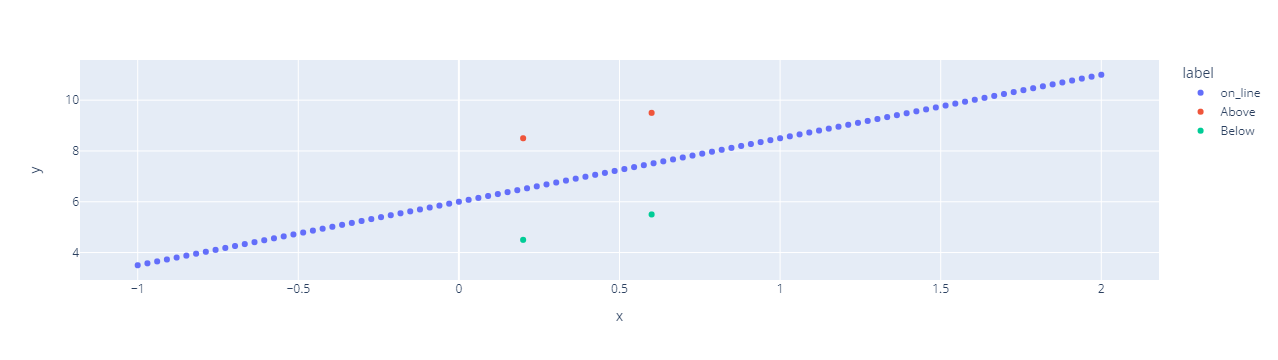

In [56]:
px.scatter(data, x='x', y='y', color = 'label')